In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.special import softmax
from scipy.spatial.distance import euclidean

# MS: TODO comment out for now
#import biomart


import umap
import pickle
import scipy.spatial as sp
import seaborn as sns
import itertools

from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris

from scipy.spatial.distance import pdist,squareform
from scipy.cluster import hierarchy

import glob

In [6]:
class HopfieldResolver(object):
    def __init__(self, patterns,w,beta,tmax=10):
        self.patterns = patterns.copy()
        self.w = w
        self.tmax = tmax
        self.beta = beta
        self.resolved_patterns = np.array([])
        self.t = np.array([])
    def resolve_pattern_iteration(self,x,beta):
        raise NotImplementedError
        
    def resolve(self,x0,dt=None,sigma=0,activation_vec=None):
        self.dt = dt
            
        if type(activation_vec)==type(None):
            activation_vec = np.zeros(x0.shape[0])
        if len(self.resolved_patterns) == 0:
            self.resolved_patterns = np.array(x0).reshape(1,x0.shape[0])
        self.x = x0.copy()
        
        tmin = 0.0 if len(self.t)==0 else self.t.max()+self.dt
        for t in np.arange(tmin,tmin+self.tmax,self.dt):
            self.x += dt*(activation_vec + self.resolve_pattern_iteration(self.x,self.beta(t)) -self.x) + sigma*np.sqrt(dt)*np.random.normal(size=self.x.shape[0])
            self.resolved_patterns = np.append(self.resolved_patterns,self.x.copy().reshape(1,x0.shape[0]),axis=0)
            self.t = np.append(self.t,t)
    def resolve_continous(self,x0,dt=.1,sigma=0,activation_vec=None):
        self.resolve(x0,dt=dt,sigma=sigma,activation_vec=activation_vec)
        
    def generate_avgd_patterns(self):
        self.combinations = np.array(list(itertools.product([0, 1], repeat=self.patterns.shape[0])))[1:]
        self.avgd_patterns = [self.patterns[np.argwhere(v==1)].mean(axis=0)[0] for v in self.combinations]
        
    def calc_dists(self):
        return [euclidean(self.resolved_patterns[-1],pattern) for pattern in self.patterns]
            
class SoftmaxResolver(HopfieldResolver):
    def calc_activation(self,rpat):
        return np.matmul(self.patterns,rpat)
    def energy(self,x):
        return - (1/self.beta(0))*np.log(np.exp(self.w + self.beta*self.calc_activation(x)).sum())+0.5*np.matmul(x.T,x)

    def resolve_pattern_iteration(self,x,beta):
        return np.matmul(self.patterns.T,softmax(self.w + beta*self.calc_activation(x)))


class Genome(object):
    def __init__(self,etf_mapping,eprofiles):
        self.etf_mapping = etf_mapping
        self.eprofiles = eprofiles
        
        self.MAX_TF = np.max([np.max(x) for x in self.eprofiles.values()])+1
        
    
        self.MAX_ENLOC = np.sum([len(x) for x in self.etf_mapping.values()])
        self.Q = np.zeros([self.MAX_ENLOC,self.MAX_TF])
        self.XI = np.zeros([self.MAX_ENLOC,self.MAX_TF])
        self.epf = np.zeros(self.MAX_ENLOC)
        
        i = 0
        for key in range(max(self.etf_mapping.keys())+1):
            for loc in range(len(self.etf_mapping[key])):
                self.XI[i,self.eprofiles[key]]=1
                self.Q[i,self.etf_mapping[key][loc]]=1
                self.epf[i] = key
                i+=1
        self.XI_renorm()
        
                
    def XI_renorm(self):
        norm_ = np.linalg.norm(self.XI,axis=1)
        self.XI = np.array([self.XI[i]/norm_[i] for i in range(self.XI.shape[0])])
        
    def run(self,x0,w,beta,dt=0.1,tmax=10):
        x=x0.copy()
        hist = []
        for t in np.arange(0,tmax,dt):
            hist.append(x.copy())
            x+=dt*(np.matmul(self.Q.T,softmax(w+beta*np.matmul(self.XI,x)))-x)
            
        hist = np.array(hist)
        return x,hist
    
    def plot_hist(self,ax,hist,label):
        ax.imshow(hist.T,aspect=1.5*hist.shape[0]/hist.shape[1],vmin=0,vmax=.5,cmap="Greens")
        ax.set_xticks([])
        ax.set_yticks(np.arange(-.5,self.XI.shape[1]+.5),minor=True)
        ax.set_ylabel("TF")
        ax.set_xlabel("time")
        ax.grid(visible=True, which='major', color='gray',lw=0)
        ax.grid(visible=True, which='minor', color='gray',lw=1)
        ax.set_title(label)
        fig.tight_layout()
    

# Library

# Figure 2

In [3]:
reprog_paths = pd.read_csv("../tabula_muris/direct_reprogramming_recipes.csv")
reprog_facts = []
_=[[reprog_facts.append(y) for y in x.split(",")] for x in reprog_paths.factors.values]
reprog_facts=np.unique(reprog_facts)
inv_mapping = pickle.load(open('../inv_mapping.pickle','rb'))
mapping = pickle.load(open('../mapping.pickle','rb'))
annotations = pd.read_csv("../tabula_muris/annotations_facs.csv").set_index('cell')
metadata = pd.read_csv("../tabula_muris/metadata_FACS.csv")

rel_ctypes = [
          'Bergmann glial cell',
          'Brush cell of epithelium proper of large intestine',
          'Kupffer cell',
          'astrocyte',
          'basal cell', 
          'basal cell of epidermis', 
          'basophil', 
          'bladder cell',
          'bladder urothelial cell', 
          'brain pericyte',
          'cardiac muscle cell',
          'ciliated columnar cell of tracheobronchial tree', 
          'endocardial cell',
          'endothelial cell of hepatic sinusoid',
          'enterocyte of epithelium of large intestine', 
          'enteroendocrine cell',
          'epidermal cell', 
          'epithelial cell of large intestine', 
          'epithelial cell of lung',
          'epithelial cell of proximal tubule', 
          'erythrocyte', 
          'fibroblast',
          'hepatocyte',
          'B cell', 'T cell',
          'natural killer cell',
          'keratinocyte',
          'kidney collecting duct epithelial cell',
          'large intestine goblet cell',
          'luminal epithelial cell of mammary gland', 
          'lung endothelial cell',
          'macrophage',
          'mesenchymal cell',
          'microglial cell', 
          'monocyte', 
          'myofibroblast cell',
          'neuron', 
          'oligodendrocyte',
          'pancreatic A cell',
          'pancreatic D cell', 
          'pancreatic PP cell', 
          'pancreatic acinar cell',
          'pancreatic ductal cell', 
          'pancreatic stellate cell',
          'professional antigen presenting cell', 
          'skeletal muscle satellite cell', 
          'smooth muscle cell', 
          'stromal cell',
          'type B pancreatic cell']

FileNotFoundError: [Errno 2] No such file or directory: '../tabula_muris/direct_reprogramming_recipes.csv'

In [6]:
def initialize_ctypes():
    def load_tabmuris_data(fs):
        total_data_tfs = []
        for f in fs:
            data =pd.read_csv(f,index_col=0)
            new_idx_tfs = []
            for x in data.index:
                if x in inv_mapping.keys() and inv_mapping[x] in tfs.index:
                    new_idx_tfs.append(x)
                elif x in ["Spi1","Lmo2"]:
                    new_idx_tfs.append(x)
            data_tfs = data.loc[new_idx_tfs].T
            total_data_tfs.append(data_tfs)
        total_data_tfs = pd.concat(total_data_tfs)
        return total_data_tfs

    def gen_ctype_lst(dataset):
        lst = []
        ctypes = []
        for j in dataset.index:
            lst.append(j in annotations.index)
            if lst[-1]:
                ctypes.append(annotations.loc[j].cell_ontology_class)
        return ctypes,lst
    def load_and_generate_avgd_by_celltypes():

        total_data_tfs = load_tabmuris_data(glob.glob("tabula_muris/FACS/*"))
        ctypes,lst = gen_ctype_lst(total_data_tfs)
        total_data_tfs = total_data_tfs[lst]
        avgd_by_ctype = total_data_tfs.groupby(ctypes).mean()
        avgd_by_ctype.to_csv("../tabula_muris/avgd_by_ctype.csv")
        
def load_ctype_patterns():
    avgd_by_ctype = pd.read_csv("../tabula_muris/avgd_by_ctype.csv",index_col=0)
    return avgd_by_ctype

def preprocess_ctype_patterns(patterns):
    df = np.log1p(patterns)
    rel_tfs = list(set(list(df.columns[(df.max()>0) & (df.mean()>np.log1p(3)) & (df.std()>np.log1p(3))].values)  + list(reprog_facts)))
    #df=patterns
    df = df.loc[:,set(rel_tfs)]
    return df

In [7]:
def initialize_patterns(df,x0_name="fibroblast"):
    patterns = (df.copy().values)
    norm_ = np.linalg.norm(patterns,axis=1)
    patterns = np.array([patterns[i]/norm_[i] for i in range(patterns.shape[0])])

    x0 = patterns[np.argwhere(df.index==x0_name)[0][0]]
    K,N=patterns.shape
    w=np.zeros(K)
    return patterns,x0,K,N,w

def run_reprogramming(df,idx,reprog_paths,pulse_params):

    
    path = reprog_paths.iloc[idx]
    patterns,x0,K,N,w = initialize_patterns(df,x0_name=path.loc["source cell"])
    
    activation_vec =pd.Series(np.zeros(N),index=df.columns)
    activation_vec.loc[path.loc["factors"].split(",")]=[float(x) for x in path.loc["weights"].split(",")]
    
    solver = SoftmaxResolver(patterns,w,beta=lambda t: pulse_params["BETA"],tmax=pulse_params["tpulse"])
    solver.resolve_continous(x0,dt=0.1,sigma=0)
    solver.resolve_continous(x0,dt=0.1,sigma=0,activation_vec=activation_vec.values)
    solver.resolve_continous(solver.resolved_patterns[-1],dt=0.1,sigma=0)
    
    str_ = r"%s to %s by %s" % (reprog_paths.iloc[idx]["source cell"].capitalize(),reprog_paths.iloc[idx]["target cell"].capitalize(), reprog_paths.iloc[idx]["factors"])
    
    return solver,str_

In [39]:
df = preprocess_ctype_patterns(load_ctype_patterns().loc[rel_ctypes])
pd.DataFrame(df.index).to_csv("../outputs/TM_Celltypes.csv",header=False, index=False)
pd.DataFrame(df.columns).to_csv("../outputs/TM_TFs.csv",header=False, index=False)
pulse_params = {"BETA" : 120, "tpulse" : 10}
reprog_trajs = []
for i in range(reprog_paths.shape[0]):
    solver,str_ = run_reprogramming(df,i,reprog_paths,pulse_params)
    print("PREDICTION: ",str_)
    print("RESULT:", df.index[np.argmin(solver.calc_dists())])
    reprog_trajs.append(solver.resolved_patterns)

<ipython-input-6-1d781e68416f>:41: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df.loc[:,set(rel_tfs)]


PREDICTION:  Fibroblast to Neuron by Ascl1,Lhx3,Mnx1,Isl1,Neurog2,Pou3f2,Myt1l
RESULT: neuron
PREDICTION:  Fibroblast to Neuron by Ascl1,Pou3f2,Myt1l
RESULT: neuron
PREDICTION:  Fibroblast to Neuron by Ascl1
RESULT: neuron
PREDICTION:  Fibroblast to Oligodendrocyte by Sox10,Zfp536,Olig2
RESULT: oligodendrocyte
PREDICTION:  Fibroblast to Lung endothelial cell by Foxo1,Etv2,Klf2,Tal1
RESULT: lung endothelial cell
PREDICTION:  Fibroblast to Type b pancreatic cell by Neurog3,Pdx1,Mafa
RESULT: type B pancreatic cell
PREDICTION:  Fibroblast to Hepatocyte by Foxa1,Foxa2,Foxa3,Hnf4a
RESULT: hepatocyte
PREDICTION:  Fibroblast to Cardiac muscle cell by Gata4,Mef2c,Tbx5
RESULT: cardiac muscle cell
PREDICTION:  Fibroblast to Skeletal muscle satellite cell by Myod1
RESULT: skeletal muscle satellite cell
PREDICTION:  Fibroblast to Epidermal cell by Trp63,Klf4
RESULT: epidermal cell
PREDICTION:  B cell to Monocyte by Cebpa,Cebpb
RESULT: monocyte
PREDICTION:  Pancreatic ductal cell to Type b pancreati

In [9]:
def plot_attractor_traj(pca,ax,patterns,noise=0.2):
    ax.scatter(pca_data[:,0],pca_data[:,1],c='gray',s=50)

    for i in range(patterns.shape[0]):
        x0=patterns[i].copy()*np.random.normal(1,noise,patterns.shape[1])
        w=np.zeros(patterns.shape[0])
        solver = SoftmaxResolver(patterns,w,beta=lambda t: 120,tmax=100)
        solver.resolve_continous(x0)
        traj = pca.transform(solver.resolved_patterns)
        ax.plot(traj[:,0],traj[:,1],c='r',lw=3)

    ax.grid(False)
    ax.set_facecolor('white')
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_yticks([])
    ax.set_xticks([])

source cell                                   fibroblast
target cell                                       neuron
factors                                            Ascl1
weights                                                1
ref            https://pubmed.ncbi.nlm.nih.gov/25254342/
Name: 2, dtype: object


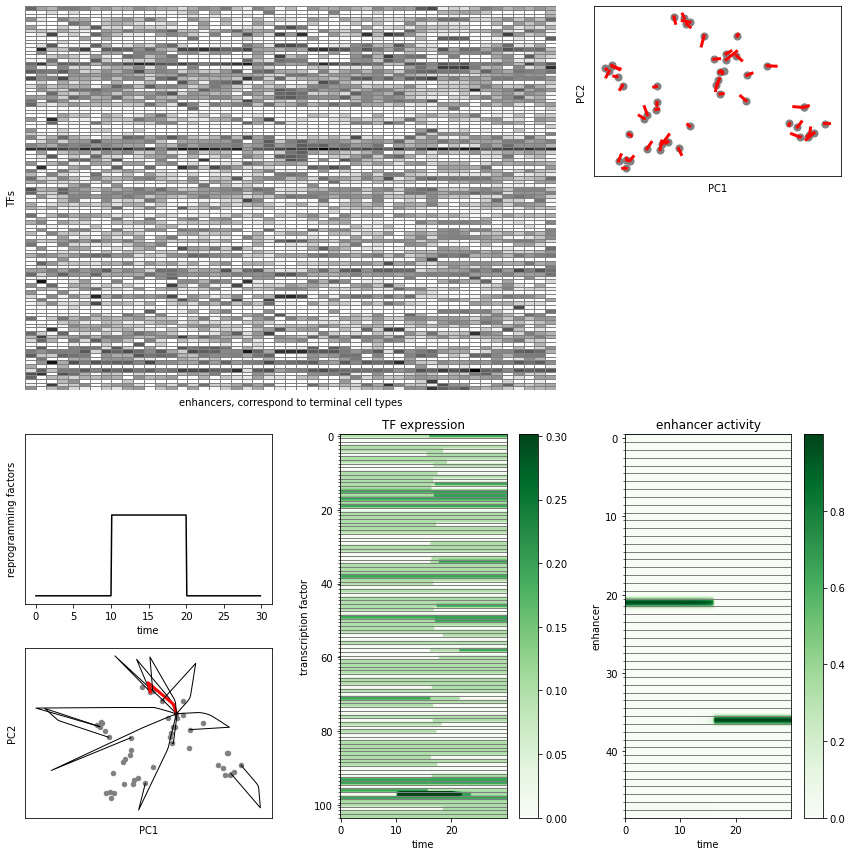

In [10]:
# Define the plot grid layout
patterns,_,_,_,_ = initialize_patterns(df)

reprog_idx = 2
print(reprog_paths.iloc[reprog_idx])
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(4, 3)

# Create the individual subplots

empty = fig.add_subplot(grid[1,-1])
heatmap_ax = fig.add_subplot(grid[:2,:-1])
idxs=[x.lower() for x in df.index]
cg=sns.heatmap(pd.DataFrame(1-patterns/patterns.max(),index=idxs,columns=df.columns).T,annot_kws={"size": 30}, cmap='gray',vmin=0,vmax=1,
            cbar_kws=dict(ticks=[0, 0.50, 1],orientation='horizontal'),ax=heatmap_ax,cbar=False,xticklabels=False,yticklabels=False,
            linewidths=1, linecolor='gray')
ax=heatmap_ax
K,N=patterns.shape
ax.set_ylabel("TFs")
ax.set_xlabel("enhancers, correspond to terminal cell types")
ax.set_ylabel("TFs")
ax.set_xlabel("enhancers, correspond to terminal cell types")

corrmap_ax = fig.add_subplot(grid[0,-1])

pulse_plot = fig.add_subplot(grid[2,0])
pca_ax = fig.add_subplot(grid[3,0 ])
tf_axs = fig.add_subplot(grid[2:,1])
en_axs = fig.add_subplot(grid[2:,2])

empty.set_facecolor('white')
empty.set_axis_off()

pulse_plot.set_facecolor('white')
pulse = lambda t: 1*(t>pulse_params["tpulse"])*(t<2*pulse_params["tpulse"])
pulse_plot.plot(solver.t,pulse(solver.t),c='k')
pulse_plot.set_yticks([])
pulse_plot.set_xlabel('time')
pulse_plot.set_ylabel('reprogramming factors')
pulse_plot.set_ylim([-0.1,2])



ax = pca_ax
pca = PCA(n_components=2)
pca.fit(patterns)
pca_data = pca.transform(patterns)
ax.scatter(pca_data[:,0],pca_data[:,1],c='gray',s=20)

umap_patterns=[]
id_list = []

idict = {}
cnt = 0
for i in range(pca_data.shape[0]):
    if (df.index[i] in reprog_paths.loc[:,"source cell"].values) or (df.index[i] in reprog_paths.loc[:,"target cell"].values):
        if df.index[i] not in idict.keys():
            idict[df.index[i]]=cnt
            cnt = cnt + 1
    
reprog_trajs = []
for i in range(reprog_paths.shape[0]):
    solver,str_ = run_reprogramming(df,i,reprog_paths,pulse_params)
    reprog_trajs.append(solver.resolved_patterns)
    pca_traj = pca.transform(solver.resolved_patterns)
    if i==reprog_idx:
        ax.plot(pca_traj[:,0],pca_traj[:,1],lw=3,label=str_,c='r')
    else:
        ax.plot(pca_traj[:,0],pca_traj[:,1],lw=1,label=str_,c='k')
ax.grid(False)
ax.set_facecolor('white')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_yticks([])
ax.set_xticks([])



trajs=reprog_trajs[reprog_idx]
trajs_ = np.round(trajs,1)
dist_arr = np.array([[np.corrcoef(traj,patterns[i])[0,1] for i in range(patterns.shape[0])] for traj in trajs])
enhancer_probs = np.array([(np.exp(pulse_params["BETA"]*np.matmul(patterns,traj))/np.exp(pulse_params["BETA"]*np.matmul(patterns,traj)).sum()) for traj in trajs])


ax=tf_axs
aspect=.15
cax=ax.imshow(trajs_.T,aspect=1/aspect,vmin=0,vmax=patterns.max(),cmap="Greens")
ax.set_yticks(np.arange(-.5,patterns.shape[1]+.5),minor=True)
ticks=np.arange(0,trajs.shape[0]-1,100)
ax.set_xticks(ticks)
ax.set_xticklabels([int(np.round(x)) for x in solver.t[ticks]])
ax.grid(visible=True, which='major', color='gray',lw=0)
ax.grid(visible=True, which='minor', color='gray',lw=1)
ax.set_ylabel("transcription factor")
ax.set_xlabel("time")
cbar=plt.colorbar(ax=ax,mappable=cax)
ax.set_title("TF expression")





ax=en_axs
rel_rat = enhancer_probs.shape[-1]/trajs_.shape[-1]
cax=ax.imshow(enhancer_probs.T,vmin=0,vmax=enhancer_probs.max(),aspect=1/(rel_rat*aspect),cmap='Greens')
ax.set_yticks(np.arange(-.5,patterns.shape[0]+.5),minor=True)
ticks=np.arange(0,trajs.shape[0]-1,100)
ax.set_xticks(ticks)
ax.set_xticklabels([int(np.round(x)) for x in solver.t[ticks]])
ax.grid(visible=True, which='major', color='gray',lw=0)
ax.grid(visible=True, which='minor', color='gray',lw=1)
ax.set_ylabel("enhancer")
ax.set_xlabel("time")
cbar=plt.colorbar(ax=ax,mappable=cax)
ax.set_title("enhancer activity")


plot_attractor_traj(pca,corrmap_ax,patterns)


fig.tight_layout()

plt.savefig('../figures/enhancer_selection.png', dpi=600)


# Figure 3

In [11]:
terminal_lineages = ['B Cell Lineage', 'Basophil Lineage', 'Dendritic Cell Lineage',
                     'Eosinophil Lineage', 'Erythrocyte Lineage', 'Macrophage Lineage',
                      'Mast Cell Lineage', 'Megakaryocyte Lineage','NK Cell Lineage', 'Neutrophil Lineage',
                      'T Cell Lineage']

tfs = pd.read_csv("../haemopoiesis/mouse_ensemble_tfs_from_lambertetal_isyes.unique.txt",names=["geneId",]).set_index("geneId")
data = pd.read_csv("../haemopoiesis/Haemopedia-Mouse-RNASeq_tpm.txt",sep='\t').set_index("geneId")
samples = pd.read_csv("../haemopoiesis/Haemopedia-Mouse-RNASeq_samples.txt",sep='\t')

data_reduced_merged_lineage = pd.merge(samples.loc[:,["sampleId","cell Type Description","cell_lineage"]],data.T.reset_index().rename(columns={'index': 'sampleId'})).groupby("cell_lineage").mean()
data_reduced_merged_lineage = data_reduced_merged_lineage.drop(["Multi Potential Progenitor","Restricted Potential Progenitor"])

data_reduced_merged = data_reduced_merged_lineage.copy()
data_reduced_merged_log = np.log1p(data_reduced_merged)

# get all variable TFs
data_reduced =data_reduced_merged_log.loc[:,np.intersect1d(tfs.index.values,data_reduced_merged_log.columns)]
data_reduced = data_reduced.loc[:,data_reduced.max()>0]
data_reduced = data_reduced.loc[:,data_reduced.mean()>np.log1p(3)]
data_reduced = data_reduced.loc[:,data_reduced.std()>np.log1p(3)]

data_reduced.index=[x.split(" Lineage")[0] for x in data_reduced.index]


pd.DataFrame(data_reduced.index).to_csv("../outputs/HEM_Celltypes.csv",header=False, index=False)
pd.DataFrame([mapping[x] for x in data_reduced.columns]).to_csv("../outputs/HEM_TFs.csv",header=False, index=False)

<ipython-input-11-4114176b6447>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_reduced_merged_lineage = pd.merge(samples.loc[:,["sampleId","cell Type Description","cell_lineage"]],data.T.reset_index().rename(columns={'index': 'sampleId'})).groupby("cell_lineage").mean()


In [30]:

def est_heatmap(ax,data_reduced,dist_mat,order):
    sns.set(font_scale=1.4)
    cg=sns.heatmap(dist_mat.loc[order[::-1],order[::-1]],annot_kws={"size": 30},cmap='crest',
                  cbar_kws=dict(orientation='vertical',location='right'),ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.collections[0].colorbar.set_label(r'$1-\cos{\theta}$')
    fig.tight_layout()

def est_dendrogram(ax,data_reduced):
    ydist = pdist(data_reduced,metric='cosine')
    dist_mat = pd.DataFrame(squareform(ydist), index=data_reduced.index, columns= data_reduced.index)

    Z = hierarchy.linkage(100*ydist, 'average')
    dn = hierarchy.dendrogram(Z,labels=data_reduced.index,orientation='left',leaf_rotation=0,
                              color_threshold=0,above_threshold_color='k',
                              leaf_font_size=0,ax=ax,show_leaf_counts=True)
    ax.set_yticks([])
    ax.set_xticks([])
    hierarchy.set_link_color_palette(None) 
    
    ax.grid(False)
    ax.set_facecolor('white')
    return dist_mat,dn['ivl']
    
    
def simple_model(en_ax,tf_ax,beta_ax,patterns_ax):
    N = 9 # bits
    K=6 # overall patterns


    patterns = np.random.normal(size=(K,N))

    patterns[:,:] = 0
    patterns[0][:2] = 1
    patterns[1][1:3] = 1
    patterns[2][3:5] = 1
    patterns[3][4:6] = 1
    patterns[4][6:8] = 1
    patterns[5][7:9] = 1

    norm_ = np.linalg.norm(patterns,axis=1)
    patterns = np.array([patterns[i]/norm_[i] for i in range(patterns.shape[0])])
    x0 = patterns[0]
    w = np.repeat(0.0,K)
    w[4]=0.05

    tmax = 100
    beta = lambda t: 6 if t < 10 else 1 + 5 * t/tmax
    solver = SoftmaxResolver(patterns,w,beta=beta,tmax=tmax)
    solver.resolve_continous(x0,dt=0.1,sigma=0)


    enhancer_probs = np.array([(np.exp(beta*np.matmul(patterns,traj))/np.exp(beta*np.matmul(patterns,traj)).sum()) for traj,beta in zip(solver.resolved_patterns,[beta(t) for t in solver.t])])

    ax=en_ax
    ax.imshow(enhancer_probs.T,aspect=.5*enhancer_probs.shape[0]/enhancer_probs.shape[1],vmin=0,vmax=1,cmap="Greens")
    ax.set_yticks(range(K))
    ax.set_xticks([10,350,600,900])
    ax.set_xticklabels([r'high $\beta$',r'low $\beta$',r'med. $\beta$',r'high $\beta$'],rotation=90)
    ax.set_yticks(np.arange(-.5,enhancer_probs.shape[1]+.5),minor=True)
    ax.set_yticklabels([(i+1) for i in range(K)])

    ax.grid(visible=True, which='major', color='gray',lw=0)
    ax.grid(visible=True, which='minor', color='gray',lw=1)
    ax.set_ylabel('enhancer')

    ax=tf_ax
    ax.imshow(solver.resolved_patterns.T,aspect=.5*solver.resolved_patterns.shape[0]/solver.resolved_patterns.shape[1],vmin=0,vmax=1,cmap="Greens")
    ax.set_yticks(range(N))
    ax.set_xticks([10,350,600,900])
    ax.set_xticklabels([r'high $\beta$',r'low $\beta$',r'med. $\beta$',r'high $\beta$'],rotation=90)
    ax.set_yticks(np.arange(-.5,patterns.shape[1]+.5),minor=True)
    ax.set_yticklabels([(i+1) for i in range(N)])

    ax.grid(visible=True, which='major', color='gray',lw=0)
    ax.grid(visible=True, which='minor', color='gray',lw=1)
    ax.set_ylabel('TF')


    ax=patterns_ax
    ax.imshow(patterns.max()-patterns.T,aspect=.5*patterns.shape[0]/patterns.shape[1],cmap='gray',vmin=0,vmax=patterns.max())
    ax.set_yticks(range(N))
    ax.set_xticks(range(K))
    ax.set_yticks(np.arange(-.5,N+.5),minor=True)
    ax.set_xticks(np.arange(-.5,K+.5),minor=True)
    ax.grid(visible=True, which='major', color='gray',lw=0)
    ax.grid(visible=True, which='minor', color='gray',lw=1)
    ax.set_xticklabels(['EN%d'%(i+1) for i in range(K)],rotation=90)
    ax.set_yticklabels(['TF%d'%(i+1) for i in range(N)],rotation=0)

    ax=beta_ax
    ax.plot(solver.t,[beta(t_) for t_ in solver.t],c='k')
    ax.set_ylabel(r"$\beta$")
    ax.set_xlabel("time")
    ax.set_ylim([1,6.1])
    ax.set_yticks([1,3,5])
    ax.grid(False)
    ax.set_facecolor('white')
    



In [34]:

def gen_umap_patterns(data_reduced):
    BETA = 50
    SIGMA = 0.01 # noise magnitude
    def initialize_patterns(data_reduced):
        patterns = data_reduced.copy().values
        norm_ = np.linalg.norm(patterns,axis=1)
        patterns = np.array([patterns[i]/norm_[i] for i in range(patterns.shape[0])])

        x0 = patterns.mean(axis=0)
        K,N=patterns.shape
        w=np.zeros(K)
        return patterns,x0,K,N,w

    def betafunc():
        beta_=BETA
        tmax=beta_
        beta=lambda t: beta_*t/tmax
        return beta,tmax


    def wadj_noise(sigma=SIGMA,max_=1000):
        patterns,x0,K,N,w = initialize_patterns(data_reduced)
        beta,tmax = betafunc()
        w=pd.Series(np.zeros(K),index=data_reduced.index)
        hist_=[]
        for iter_ in range(max_):
            solver = SoftmaxResolver(patterns,w,beta=beta,tmax=tmax)
            solver.resolve_continous(x0,sigma=sigma)
            dists_ = solver.calc_dists()
            j = np.argmin(dists_)
            w[j]-=.5*(1-iter_/max_)
            w=w-w.mean()
        return w

    # initalize balanced weight vector
    w=wadj_noise()

    # generate trajectories
    hist=np.array([])
    patterns,x0,K,N,_ = initialize_patterns(data_reduced)
    solvers = []
    for iter_ in range(1000):
        beta,tmax = betafunc()
        solver = SoftmaxResolver(patterns,w,beta=beta,tmax=tmax)
        solver.resolve_continous(x0,sigma=SIGMA)
        dists_ = solver.calc_dists()
        j = np.argmin(dists_)
        hist =np.append(hist,j)
        if (hist==j).sum()<20:
            solvers.append(solver)

    umap_patterns=[]
    id_list = []
    for s in solvers:
        id_ = np.argmin(s.calc_dists())
        id_list.append(id_)
        umap_patterns.append(s.resolved_patterns[5::5])
        ln = len(umap_patterns[-1])

    umap_patterns = np.concatenate(umap_patterns)
    ft = umap.UMAP(n_neighbors=15).fit_transform(umap_patterns)
    
    return umap_patterns,ft,ln,id_list

def plot_umap_pattenrs(ax,umap_patterns,ft,ln,id_list,data_reduced):
    colors = ['red','green','purple','blue','gold','gray','orange','#1f77b4', '#8c564b','#e377c2','#17becf']

    used_ids = []

    for idx,id_ in zip(np.arange(0,ft.shape[0],ln),id_list):
        ax.scatter(ft[idx:idx+ln,0],ft[idx:idx+ln,1],c=colors[id_])
        ax.plot(ft[idx:idx+ln,0],ft[idx:idx+ln,1],c=colors[id_],lw=.1)
        if not id_ in used_ids:
            ax.text(ft[idx+ln-1,0]-3,ft[idx+ln-1,1]+.5,data_reduced.index[id_],fontsize=20)
            used_ids.append(id_)
    ax.set_xlabel("UMAP 1")    
    ax.set_ylabel("UMAP 2")    
    ax.grid(False)
    ax.set_facecolor('white')

In [35]:
umap_patterns,ft,ln,id_list = gen_umap_patterns(data_reduced)

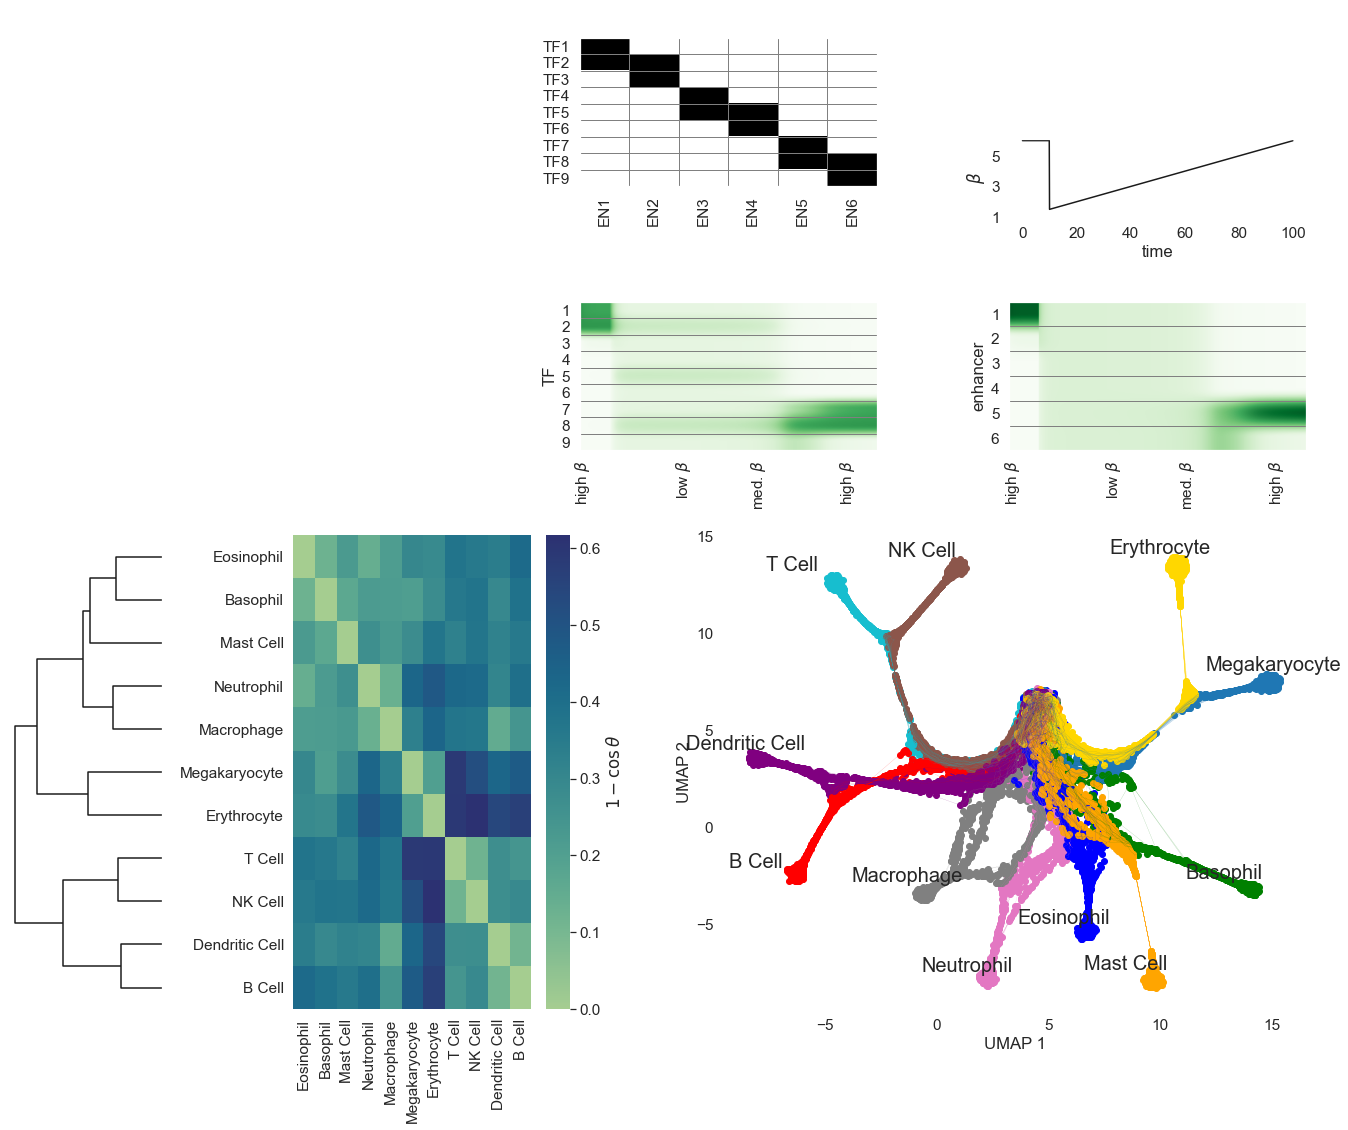

In [36]:
# perform and plot hierarchial clustering
fig = plt.figure(figsize=(19,16))
grid = fig.add_gridspec(8, 10)

empty = fig.add_subplot(grid[:2,:4])
empty.set_facecolor('white')
empty.set_axis_off()


#text_fig = fig.add_subplot(grid[2,4:6])
dendro_fig = fig.add_subplot(grid[4:,:2])
heatmap_fig = fig.add_subplot(grid[4:,2:5])
umap_fig = fig.add_subplot(grid[4:,5:])

en_ax = fig.add_subplot(grid[2:4,7:])
tf_ax = fig.add_subplot(grid[2:4,4:7])
beta_ax = fig.add_subplot(grid[1,7:])
patterns_ax = fig.add_subplot(grid[:2,4:7])
simple_model(en_ax,tf_ax,beta_ax,patterns_ax)



dist_mat,order = est_dendrogram(dendro_fig,data_reduced)
est_heatmap(heatmap_fig,data_reduced,dist_mat,order)
#plot_text(text_fig)
plot_umap_pattenrs(umap_fig,umap_patterns,ft,ln,id_list,data_reduced)

fig.tight_layout()

#plt.savefig('../figures/heatmap.png', dpi=600)


# Figure 4

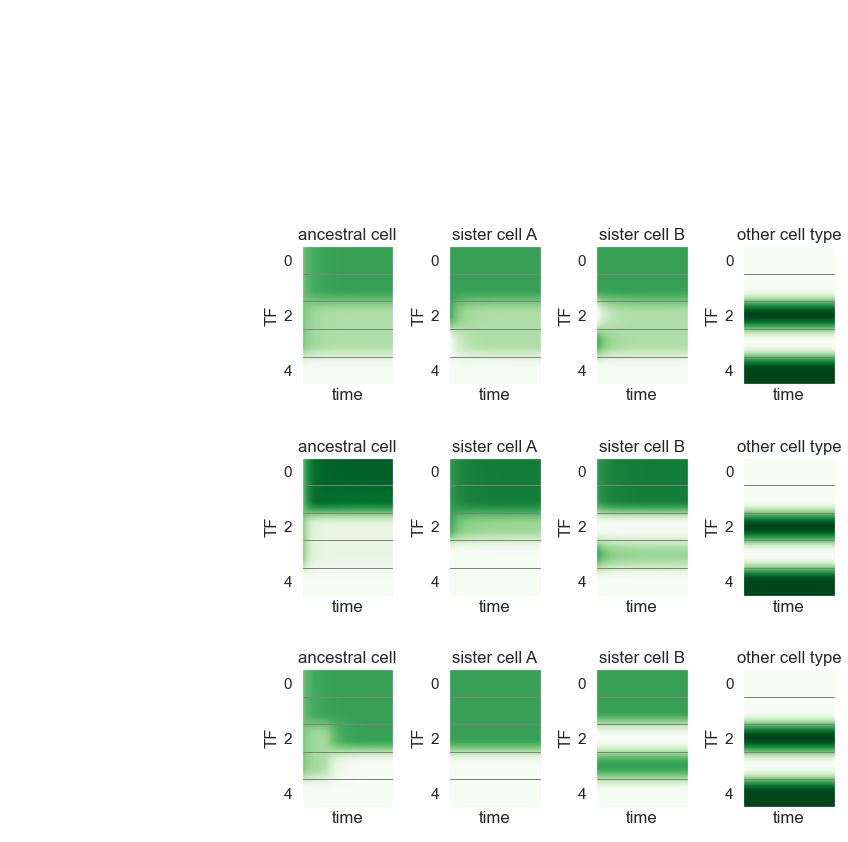

In [29]:
def run_all(genome,axs):
    def run_val(x0):
        w = np.zeros(genome.MAX_ENLOC)
        x_prof,hist = genome.run(x0,w,beta=50)
        return hist
    def run_orig():
        x0=np.zeros(genome.MAX_TF)
        x0[:4]=1/4
        return run_val(x0)
    def run_ctype_A():
        x0=np.zeros(genome.MAX_TF)
        x0[:3]=1/3
        return run_val(x0)

    def run_ctype_B():
        x0=np.zeros(genome.MAX_TF)
        x0[:2]=1/3
        x0[3]=1/3
        return run_val(x0)
    
    def run_ctype_C():
        x0=np.zeros(genome.MAX_TF)
        x0[2]=0.5
        x0[4]=0.5
        return run_val(x0)

    genome.plot_hist(axs[0],run_orig(),"ancestral cell")
    genome.plot_hist(axs[1],run_ctype_A(),"sister cell A")
    genome.plot_hist(axs[2],run_ctype_B(),"sister cell B")
    genome.plot_hist(axs[3],run_ctype_C(),"other cell type")
        

enhancer_profiles =   {0 : [0,1,2,3], 
                       1 : [0,],
                       2 : [2,],
                       3 : [2,4]}
enhancer_tf_mapping = {0 : [0,0,1,1,2,3],
                       1 : [0,],
                       2 : [2,],
                       3 : [2,4]}


fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(4, 6)


genome=Genome(enhancer_tf_mapping,enhancer_profiles)


empty=fig.add_subplot(grid[:,0])
empty.set_facecolor('white')
empty.set_axis_off()

run_all(genome,[fig.add_subplot(grid[1,j]) for j in range(2,6)])
genome.XI[5][2]=0
genome.XI[4][3]=0
run_all(genome,[fig.add_subplot(grid[2,j]) for j in range(2,6)])
genome.XI[0][2]=0
genome.XI[1][3]=0
genome.XI[2][2]=0
genome.XI[3][3]=0
run_all(genome,[fig.add_subplot(grid[3,j]) for j in range(2,6)])
fig.tight_layout()
#plt.savefig('../figures/new_ctype.png', dpi=600)
